__________________________________________________________________________________
                             |Predicting BTC with LSTM|
                                   |ConvLSTM|
                                   
Gabriel Lyra      - glgs2  
Guilherme Melo    - gacm  
Henrique Mariz    - ham2  
Matheus Belfort   - mbmt  
Matheus Lima      - mlbp  
__________________________________________________________________________________

Importando as bibliotecas necessárias

In [1]:
import warnings
warnings.filterwarnings('ignore')

#importing the libraries
import io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

%matplotlib inline

Carregando dataset

In [2]:
#loading the dataset
file = 'btc.csv'

In [3]:
#decoding the files as dataframe will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(file)
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


Removendo colunas que não devem ser utilizadas no treinamento

In [4]:
btc = btc.drop(['Date', 'Symbol'], axis=1)

Separando entrada e saída

In [5]:
features = btc['Close']
outcome = btc.drop(['Close'], axis=1)

In [6]:
outcome

,Open,High,Low,Volume From,Volume To
0,7459.11,7640.46,7380.00,2722.80000,2.042265e+07
1,7584.15,7661.85,7326.94,8491.93000,6.342069e+07
2,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
3,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
4,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
...,...,...,...,...,...
1268,377.10,377.10,377.10,0.00000,0.000000e+00
1269,378.00,378.00,377.10,0.01000,3.770000e+00
1270,378.00,378.00,377.01,0.54660,2.065200e+02
1271,370.00,378.00,370.00,15.01000,5.675070e+03


Invertendo dados

In [7]:
features = pd.DataFrame(features)
features_flipped = features["Close"].values[::-1]
features_flipped = pd.DataFrame(features_flipped)
features_flipped

,0
0,370.00
1,378.00
2,378.00
3,377.10
4,377.10
...,...
1268,7987.70
1269,7505.00
1270,7584.15
1271,7459.11


In [8]:
outcome_flipped = outcome.values[::-1]
outcome_flipped = pd.DataFrame(outcome_flipped)
outcome_flipped

,0,1,2,3,4
0,300.00,370.00,300.00,0.05656,1.953000e+01
1,370.00,378.00,370.00,15.01000,5.675070e+03
2,378.00,378.00,377.01,0.54660,2.065200e+02
3,378.00,378.00,377.10,0.01000,3.770000e+00
4,377.10,377.10,377.10,0.00000,0.000000e+00
...,...,...,...,...,...
1268,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
1269,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
1270,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
1271,7584.15,7661.85,7326.94,8491.93000,6.342069e+07


Grafico do dataset completo

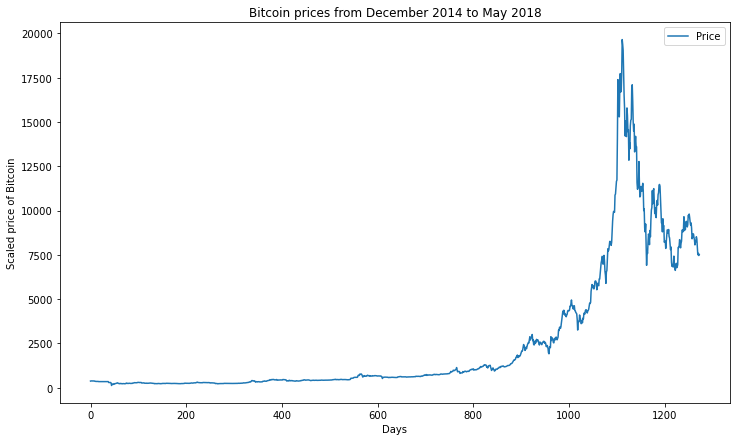

In [9]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(features_flipped, label='Price')
plt.legend()
plt.show()

Separando partes do dataset

In [10]:
close_price = np.array(features_flipped).reshape(-1,1)

In [11]:
scaler=MinMaxScaler(feature_range=(0,1))

close_priceSC = scaler.fit_transform(np.array(close_price).reshape(-1,1))

In [12]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

stepsize = 32
X, y = split_sequence(close_priceSC, stepsize)

print(X.shape, y.shape)

(1241, 32, 1) (1241, 1)


In [13]:
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [14]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 32, 1)
y_train size: (1018, 1)
X_test size: (223, 32, 1)
y_test size: (223, 1)


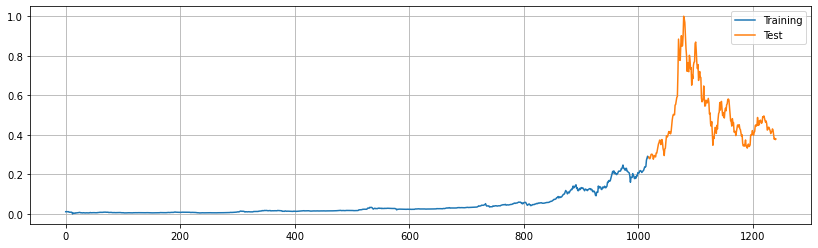

In [15]:
plt.figure(figsize=(14,4))
plt.plot(range(1018),y_train)
plt.plot(range(1018, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [16]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
print(X_train.shape)
rows = 1;
n_features = 1
n_seq = 1
X_train = X_train.reshape(-1,n_seq,rows,stepsize,n_features)
X_test = X_test.reshape(-1,n_seq,rows,stepsize,n_features)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

(1018, 32, 1)
X_train size: (1018, 1, 1, 32, 1)
y_train size: (1018, 1)
X_test size: (223, 1, 1, 32, 1)
y_test size: (223, 1)


In [17]:
#define model
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

model = Sequential()
model.add(ConvLSTM2D(filters=32, kernel_size=(1,1), input_shape=(n_seq, rows, stepsize, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 32, 32)         4352      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 24s 4ms/step - loss: 0.0038
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 2.9760e-04
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3381e-04
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3497e-04
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0699e-04
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1271e-04
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4353e-04
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1727e-04
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 8.8150e-05
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 1.0946e-04
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 8.2387e-05
Epoch 12/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0

____________________________________________________  

 --- Hiperparâmetros do Modelo ---  
stepsize  = 32
filters = 32
ativação = tahm  
otimização = adam  
batchsize = 32  
(todos os modelos foram treinados com 100 epocas)  
____________________________________________________

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [21]:
MSE = mean_absolute_error(y_test, test_predict)

Text(0, 0.5, 'Price')

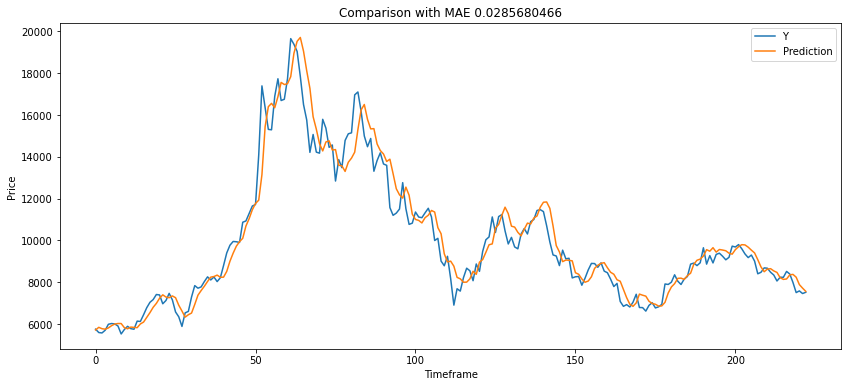

In [22]:
plt.figure(figsize=(14,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")